<a href="https://colab.research.google.com/github/KaiaLee/KaiaLee/blob/main/flightTW_ARIMA_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# 文件 ID 列表
file_ids = [
    '1EqM0JNdzGjhuOQL3SNCcRiAHdM2QoEcO',
    '1TIzwBTP7jVotetZ4IkCLIiBFARSVC80n',
    '1D0nUDKK94YF0KDAmPyj6Ll0nYtI_jbrb',
    '1uTOwQAcWdkiAcAMUrR_f0zl-iKHuW6iV',
    '1eAWWgt9PTZeqV7900_30cKTFvOag35pY',
    '1nhnpqICvAcZ3qLaN6qhQfZq0PBIX1IC0',
    '1r-yVDS-Lkpolg093cE3JWXuxFDzVJdjI',
    '1DCHXEkXMLLErUj_fAytwFajngYD2Yw88',
    '1aEqy4Av9M34c2BmVHejCN38UHA6tbHs7'
]

# 生成文件 URL
file_urls = [f'https://drive.google.com/uc?id={file_id}' for file_id in file_ids]

# 讀取並合併所有 CSV 文件
data_frames = [pd.read_csv(file_url) for file_url in file_urls]
data = pd.concat(data_frames, ignore_index=True)

# 檢查合併後的數據框
print(f"Total number of rows: {len(data)}")
print(data.head())

Mounted at /content/drive


<ipython-input-4-918f7d41fc5d>:27: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames = [pd.read_csv(file_url) for file_url in file_urls]
<ipython-input-4-918f7d41fc5d>:27: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames = [pd.read_csv(file_url) for file_url in file_urls]
<ipython-input-4-918f7d41fc5d>:27: DtypeWarning: Columns (1,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames = [pd.read_csv(file_url) for file_url in file_urls]
<ipython-input-4-918f7d41fc5d>:27: DtypeWarning: Columns (1,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames = [pd.read_csv(file_url) for file_url in file_urls]
<ipython-input-4-918f7d41fc5d>:27: DtypeWarning: Columns (1,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames = [pd.read_csv(file_url) for file_ur

Total number of rows: 4783072
                  FlightDate FlightNumber  AirRouteType AirlineID  \
0  2024-08-12 00:00:00+08:00         7016           NaN        DA   
1  2024-08-12 00:00:00+08:00         7010           NaN        DA   
2  2024-08-12 00:00:00+08:00         7012           NaN        DA   
3  2024-08-12 00:00:00+08:00         7016           NaN        DA   
4  2024-08-12 00:00:00+08:00         7012           NaN        DA   

  DepartureAirportID ArrivalAirportID      ScheduleDepartureTime  \
0                CMJ              MZG  2024-08-12 14:25:00+08:00   
1                CMJ              KHH  2024-08-12 11:40:00+08:00   
2                CMJ              KHH  2024-08-12 16:15:00+08:00   
3                CMJ              MZG  2024-08-12 14:25:00+08:00   
4                CMJ              KHH  2024-08-12 16:15:00+08:00   

  ActualDepartureTime EstimatedDepartureTime DepartureRemark  \
0                 NaN                    NaN              準時   
1                 

In [5]:
# 刪除不要的欄位
data = data.drop(columns=['AirRouteType', 'EstimatedDepartureTime', 'DepartureRemarkEn', 'Terminal', 'Gate', 'CodeShare', 'AcType', 'BaggageClaim', 'DepartureRemark', 'CheckCounter', 'UpdateTime'])

# 篩選出 'ActualDepartureTime' 為 NA 的行
is_na = data['ActualDepartureTime'].isna()
data = data.dropna(subset=['ActualDepartureTime'])

# 根據 'DepartureAirportID', 'ArrivalAirportID', 'ActualDepartureTime' 刪除重複行，保留最新一筆資料
data = data.sort_values(by=['ActualDepartureTime'], ascending=[False])
data = data.drop_duplicates(subset=['DepartureAirportID', 'ArrivalAirportID', 'ActualDepartureTime'], keep='last')

# 查看數據筆數（行數）
num_rows = len(data)
print(f"Number of rows: {num_rows}")

# 合并 'FlightNumber' 和 'Airline' 列
data['AirlineFlight'] = data['AirlineID'] + '_' + data['FlightNumber'].astype(str)
data = data.drop(columns=['AirlineID', 'FlightNumber'])

# 將字串轉換為時間序列格式
data['ScheduleDepartureTime'] = pd.to_datetime(data['ScheduleDepartureTime'])
data['ActualDepartureTime'] = pd.to_datetime(data['ActualDepartureTime'])
data['ScheduleDepartureTime'] .dt.tz

# 新增延遲時間欄位
data['Delaymin'] = (data['ActualDepartureTime'] - data['ScheduleDepartureTime']).dt.total_seconds() / 60
print(data.shape)

Number of rows: 7408
(7408, 8)


<ipython-input-5-b95b62a35adf>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['AirlineFlight'] = data['AirlineID'] + '_' + data['FlightNumber'].astype(str)


In [6]:
data['ScheduleDepartureTime'] = pd.to_datetime(data['ScheduleDepartureTime'], errors='coerce')
data['ActualDepartureTime'] = pd.to_datetime(data['ActualDepartureTime'], errors='coerce')

start_date = pd.to_datetime('2024-08-12 00:00:00').tz_localize('Asia/Taipei')
end_date = pd.to_datetime('2024-08-18 23:59:59').tz_localize('Asia/Taipei')

filtered_data = data[(data['ScheduleDepartureTime'] >= start_date) & (data['ScheduleDepartureTime'] <= end_date)]

print(filtered_data.shape)

(5490, 8)


In [7]:
!pip install statsmodels

In [8]:
#### 時間序列分解

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

date_range = pd.date_range(start='2024-08-12', end='2024-08-18', freq='h')
filtered_data = pd.DataFrame(index=date_range)
filtered_data['Delaymin'] = range(len(date_range))

# 确保索引是 DatetimeIndex
filtered_data.index = pd.to_datetime(filtered_data.index)

# 提取小时并创建 ScheduleDepartureTime 列
filtered_data['ScheduleDepartureTime'] = filtered_data.index.hour
filtered_data['Period'] = pd.cut(filtered_data.loc[:, 'ScheduleDepartureTime'], bins=[0, 8, 16, 24], labels=['Midnight', 'Day', 'Night'], right=False) # right=False左閉右開
period_data = filtered_data.groupby('Period', observed=False)['Delaymin'].sum()
print(period_data)

# 计算每组的平均迟到时间
mean_delay = filtered_data.groupby('Period')['Delaymin'].mean()

# 计算每组的样本数量
count_samples = filtered_data.groupby('Period').size()

# 合并结果到一个 DataFrame
summary = pd.DataFrame({
    'AverageDelay': mean_delay,
    'SampleCount': count_samples
})

print(summary)

Period
Midnight    3192
Day         3432
Night       3816
Name: Delaymin, dtype: int64
          AverageDelay  SampleCount
Period                             
Midnight     65.142857           49
Day          71.500000           48
Night        79.500000           48


<ipython-input-8-56fadfe72e22>:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_delay = filtered_data.groupby('Period')['Delaymin'].mean()
<ipython-input-8-56fadfe72e22>:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_samples = filtered_data.groupby('Period').size()


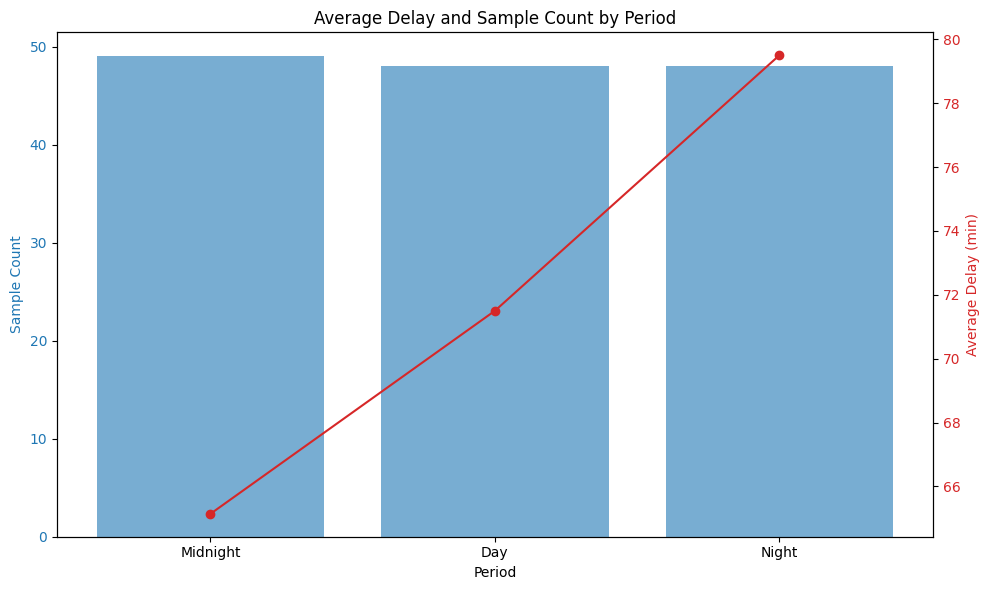

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制图形
fig, ax1 = plt.subplots(figsize=(10, 6))

# 画条形图表示每组的样本数量
color = 'tab:blue'
ax1.set_xlabel('Period')
ax1.set_ylabel('Sample Count', color=color)
ax1.bar(summary.index, summary['SampleCount'], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# 创建第二个 y 轴，用于绘制平均迟到时间
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Delay (min)', color=color)
ax2.plot(summary.index, summary['AverageDelay'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# 设置标题和图例
plt.title('Average Delay and Sample Count by Period')
fig.tight_layout()

# 显示图形
plt.show()

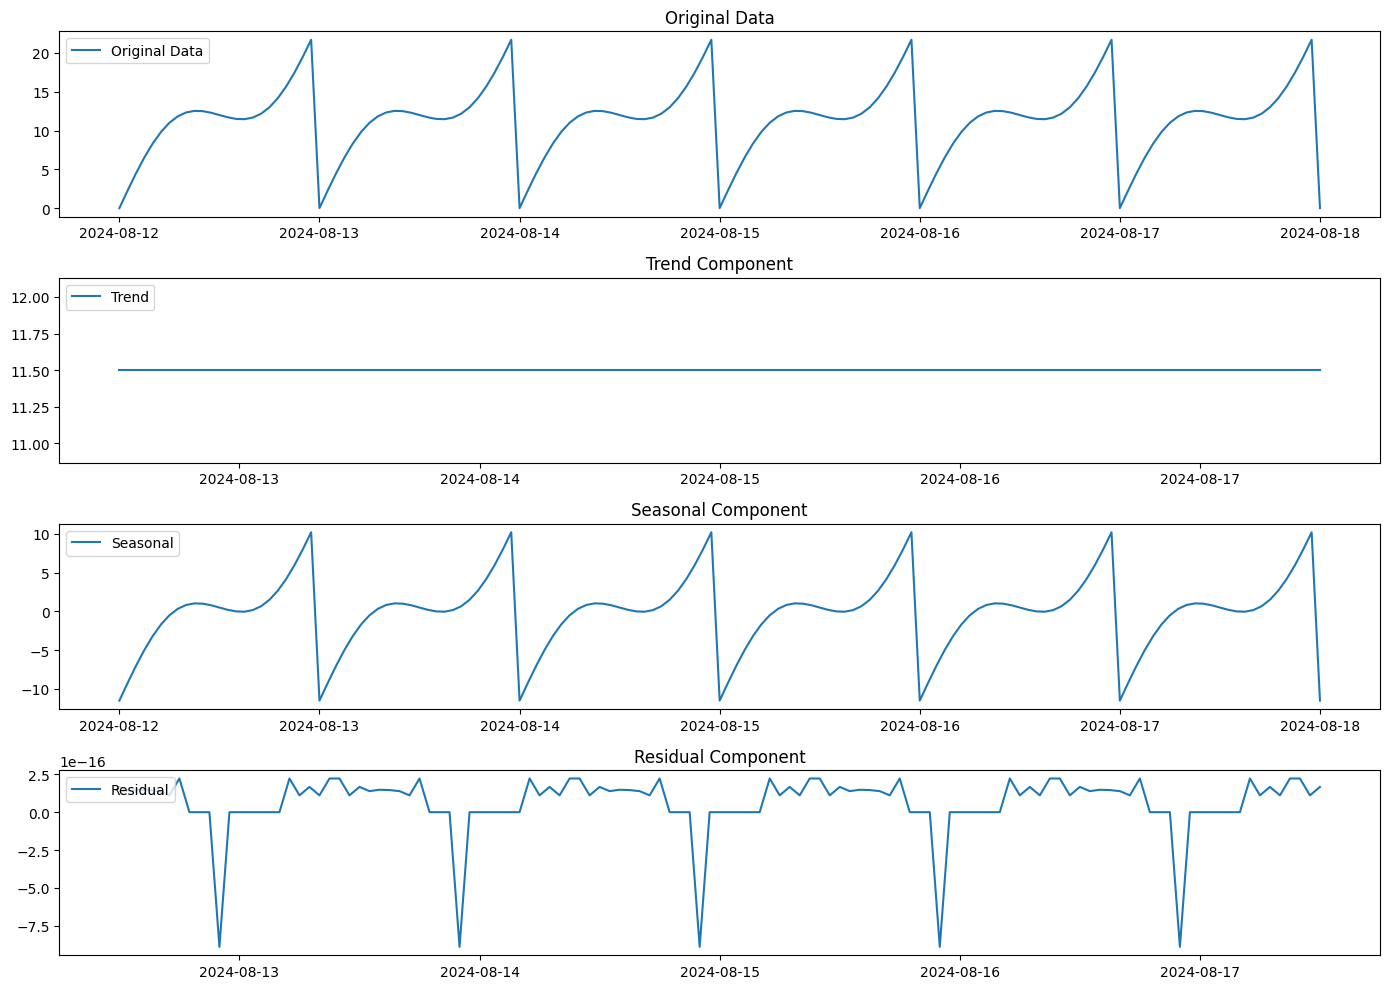

In [10]:
filtered_data_series = filtered_data['ScheduleDepartureTime']
week_data_series = pd.Series(filtered_data_series, index=date_range)

# 进行时间序列分解
# decomposition = seasonal_decompose(week_data_series, model='additive') # 或 'multiplicative'

# 7天，每天24小时，因此周期为7*24 = 168小时
seasonal_effect = 5 * np.sin(2 * np.pi * date_range.hour / 24)  # 每天内的季节性波动

# 添加季节性波动到数据中
week_data_series += seasonal_effect

# 分解时间序列
decomposition = seasonal_decompose(week_data_series, model='additive')

# 提取分解成分
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# 绘制分解结果
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(week_data_series, label='Original Data')
plt.title('Original Data')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.title('Trend Component')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.title('Seasonal Component')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.title('Residual Component')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 觀察數據平穩性

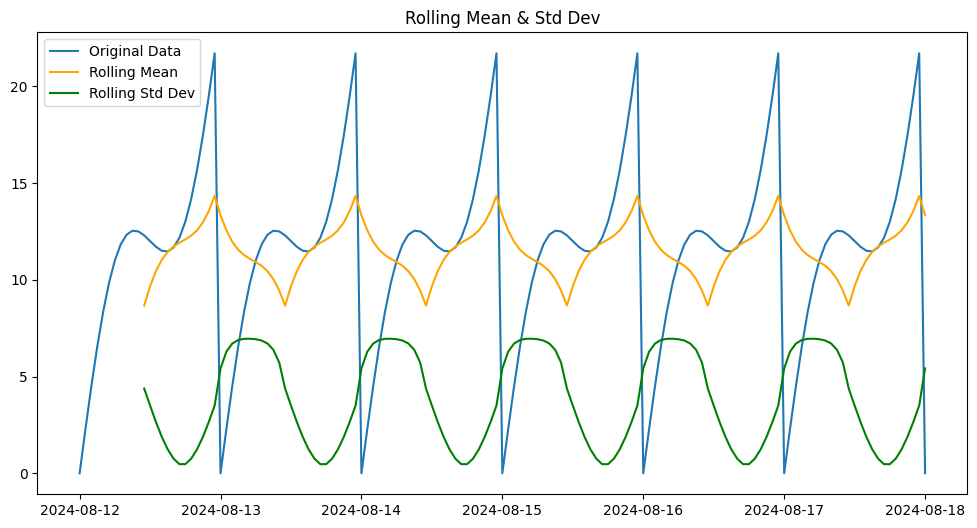

In [11]:
rolling_mean = week_data_series.rolling(window=12).mean()
rolling_std = week_data_series.rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(week_data_series, label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean', color='orange')
plt.plot(rolling_std, label='Rolling Std Dev', color='green')
plt.title('Rolling Mean & Std Dev')
plt.legend(loc='best')
plt.show()

直觀檢查數據趨勢和波動\
有明顯趨勢或周期波動可能是不平穩數據

In [12]:
from statsmodels.tsa.stattools import adfuller

# ADF 检验
result = adfuller(week_data_series.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -6.543617503728534
p-value: 9.21519878731932e-09
Critical Values: {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}


p值遠< 0.05 平穩

In [13]:
# 创建滞后特征
lag_1 = week_data_series.shift(1)  # 1小时滞后
lag_2 = week_data_series.shift(2)  # 2小时滞后

# 计算滚动统计
rolling_mean = week_data_series.rolling(window=3).mean()
rolling_std = week_data_series.rolling(window=3).std()

# 合并所有特征
data_with_features = pd.concat([week_data_series, lag_1, lag_2, rolling_mean, rolling_std], axis=1)
data_with_features.columns = ['Value', 'Lag_1', 'Lag_2', 'Rolling_Mean', 'Rolling_Std']

# 删除包含缺失值的行（由于滞后和滚动计算产生的NaN）
data_with_features = data_with_features.dropna()

print(data_with_features.head())

                         Value     Lag_1     Lag_2  Rolling_Mean  Rolling_Std
2024-08-12 02:00:00   4.500000  2.294095  0.000000      2.264698     2.250144
2024-08-12 03:00:00   6.535534  4.500000  2.294095      4.443210     2.121290
2024-08-12 04:00:00   8.330127  6.535534  4.500000      6.455220     1.916326
2024-08-12 05:00:00   9.829629  8.330127  6.535534      8.231763     1.649249
2024-08-12 06:00:00  11.000000  9.829629  8.330127      9.719919     1.338313


# ARIMA 模型建置

In [14]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 添加置後特徵
week_data_df = week_data_series.to_frame(name='Value')
week_data_df['Lag_1'] = week_data_df['Value'].shift(1)
week_data_df['Lag_2'] = week_data_df['Value'].shift(2)

# 差分處理
data_diff = week_data_series.diff().dropna()
data_diff = pd.to_numeric(data_diff, errors='coerce')

# 确保 data_diff 是一维的
if isinstance(data_diff, pd.Series):
    data_diff = data_diff.values  # 转换为 numpy.ndarray
elif isinstance(data_diff, np.ndarray):
    pass  # 已经是 numpy ndarray，无需转换
else:
    raise ValueError('data_diff 必须是 pandas Series 或 numpy ndarray')

# 确保 data_diff 不包含嵌套结构或非数字数据
if not np.issubdtype(data_diff.dtype, np.number):
    raise ValueError('data_diff 必须包含数值数据')

# ADF检验
try:
    result = adfuller(data_diff)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
except ValueError as e:
    print(f'ADF检验失败: {e}')

ADF Statistic: -6.474843596646882
p-value: 1.3390896129758975e-08
Critical Values: {'1%': -3.480118600110386, '5%': -2.8833618426136196, '10%': -2.578407034974382}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                 SARIMAX Results                                 
Dep. Variable:     ScheduleDepartureTime   No. Observations:                  116
Model:                    ARIMA(1, 1, 1)   Log Likelihood                -318.590
Date:                   Thu, 29 Aug 2024   AIC                            643.180
Time:                           05:51:06   BIC                            651.415
Sample:                       08-12-2024   HQIC                           646.522
                            - 08-16-2024                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5950      0.130      4.590      0.000       0.341       0.849
ma.L1         -0.9997      3.005     -0.333      0.739      -6.890       4.891
sigma2        14.4901     43

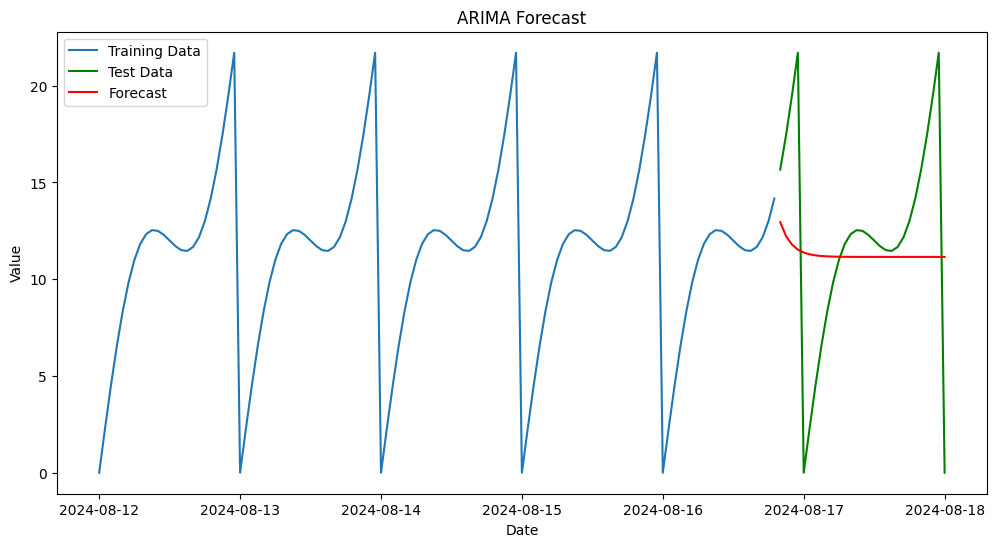

In [44]:
# 将数据分为训练集和测试集
train_size = int(len(week_data_series) * 0.8)  # 80% 作为训练集
train, test = week_data_series[:train_size], week_data_series[train_size:]

# 建立 ARIMA 模型
arima_model = sm.tsa.ARIMA(train, order=(1, 1, 1))  # 示例 order(1,1,1)，需要根据 AIC/BIC 等选择合适的参数
arima_model_fit = arima_model.fit()

# 模型摘要
print(arima_model_fit.summary())

# 进行预测
forecast = arima_model_fit.forecast(steps=len(test))  # 预测未来与测试集等长的步数
forecast_index = test.index
forecast_series = pd.Series(forecast, index=forecast_index)

# 计算预测误差
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test, forecast_series)
print(f'MSE: {mse}')

# 绘制结果
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data', color='green')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


# ARIMA 模型擬合結果
ARIMA(1, 1, 1): 表示該模型包含一個自回歸項 (AR) 和一個移動平均項 (MA)，以及一階差分 (d=1)。\
Log Likelihood: 模型的對數似然值，用於模型比較。較大的對數似然值通常表示模型擬合較好。\
AIC (Akaike Information Criterion): 用於模型選擇，值越小表示模型越好。\
BIC (Bayesian Information Criterion): 另一種模型選擇指標，也越小越好。\
HQIC (Hannan-Quinn Information Criterion): 另一種信息準則，用於模型選擇。\
coef: 模型參數的估計值。\
std err: 參數估計的標準誤差。\
z: 參數估計的z值，用於檢驗參數是否顯著。\
P>|z|: 參數的p值，用於檢驗參數顯著性。p值小於0.05通常表示參數顯著。\
sigma2: 殘差的方差估計值。\
Ljung-Box (L1) (Q): Ljung-Box檢驗用於檢測殘差的自相關性，p值大於0.05表示沒有顯著的自相關。\
Jarque-Bera (JB): 檢驗殘差的正態性，p值小於0.05表示殘差不符合正態分布。\
Heteroskedasticity (H): 檢驗殘差的異方差性，p值大於0.05表示沒有顯著的異方差。\

警告信息解釋
Non-invertible starting MA parameters found: 這個警告表示模型的初始 MA 參數可能導致模型不穩定或不適合，系統將這些參數設置為零作為初始值。這通常不會影響模型的最終結果，但可能影響模型的收斂速度和穩定性。
## 應對建議
### 模型選擇和驗證
模型診斷: 通過檢查殘差的自相關性和正態性，評估模型的適用性。可以使用殘差圖、ACF/PACF 圖和其他模型診斷工具。\
調整模型參數: 如果模型表現不佳，可以嘗試不同的參數組合（例如 AR 和 MA 的階數），或者使用更複雜的模型，如 SARIMA 或 SARIMAX。\
交叉驗證: 在不同的數據子集上測試模型的性能，以驗證其穩定性和預測能力。
### 模型改進
數據預處理: 確保數據經過適當的平穩化處理。考慮使用對數變換、季節性差分等方法改善數據的穩定性。\
其他模型: 如果 ARIMA 模型不適合，可以考慮使用其他時間序列模型，如季節性 ARIMA、LSTM、XGBoost 等。
### 警告處理
調整參數: 嘗試不同的初始化參數，或者使用自動調優工具來選擇最佳的參數配置。

# RNN 模型建置

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler

In [28]:
# 将数据转换为 DataFrame 并重命名列
week_data_df = week_data_series.to_frame(name='Value')

# 使用 Min-Max Scaler 对数据进行归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(week_data_df)

# 创建滞后特征和目标值
def create_dataset(data, lag=1):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag, 0])
        y.append(data[i+lag, 0])
    return np.array(X), np.array(y)

# 设置滞后期数
lag = 5
X, y = create_dataset(scaled_data, lag)

# 将数据重塑为 [样本数, 时间步长, 特征数]
X = X.reshape((X.shape[0], X.shape[1], 1))

# 划分训练集和测试集
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [29]:
# 构建 RNN 模型
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=50, activation='relu', input_shape=(lag, 1)))
rnn_model.add(Dense(1))

# 编译模型
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.1916 - val_loss: 0.1245
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1267 - val_loss: 0.0817
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1022 - val_loss: 0.0482
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0704 - val_loss: 0.0228
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0553 - val_loss: 0.0089
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0452 - val_loss: 0.0027
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0516 - val_loss: 0.0022
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0437 - val_loss: 0.0023
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0379 - val_loss: 0.0019
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0417 - val_loss: 0.0022
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0307 - val_loss: 0.0028
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0309 - val_loss: 0.0051
Epoch 13/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


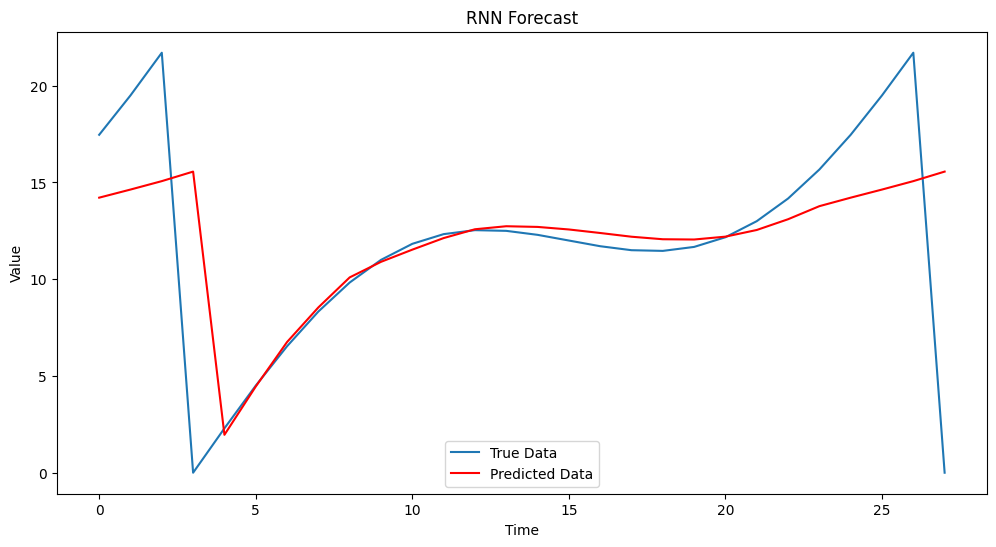

In [33]:
# 进行预测
rnn_y_pred = rnn_model.predict(X_test)

# 反归一化
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(rnn_y_pred)

# 绘制结果
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test_inv)), y_test_inv, label='True Data')
plt.plot(np.arange(len(y_pred_inv)), y_pred_inv, label='Predicted Data', color='red')
plt.legend()
plt.title('RNN Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


准备数据：对时间序列数据进行归一化和滞后特征创建。
构建RNN模型：使用Keras构建一个简单的RNN模型。
训练模型：训练模型并评估性能。
进行预测：使用模型进行未来数据的预测并可视化结果。
注意事项
数据处理：确保数据经过适当的预处理（如归一化）以适应神经网络。
参数调整：根据数据集的实际情况调整RNN的超参数，例如时间步长（lag）、RNN单元数（units）、训练轮数（epochs）等。
模型复杂性：对于复杂的时间序列问题，可能需要使用更复杂的RNN变种，如LSTM（长短期记忆网络）或GRU（门控循环单元）。

In [20]:
pip install tensorflow

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [22]:
# 将数据转换为 DataFrame 并重命名列
week_data_df = week_data_series.to_frame(name='Value')

# 使用 Min-Max Scaler 对数据进行归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(week_data_df)

# 创建滞后特征和目标值
def create_dataset(data, lag=1):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag, 0])
        y.append(data[i+lag, 0])
    return np.array(X), np.array(y)

# 设置滞后期数
lag = 5
X, y = create_dataset(scaled_data, lag)

# 将数据重塑为 [样本数, 时间步长, 特征数]
X = X.reshape((X.shape[0], X.shape[1], 1))

# 划分训练集和测试集
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [34]:
# 构建 LSTM 模型
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='relu', input_shape=(lag, 1), return_sequences=True))
lstm_model.add(LSTM(units=50, activation='relu'))
lstm_model.add(Dense(1))

# 编译模型
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.3368 - val_loss: 0.2895
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2691 - val_loss: 0.2495
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2425 - val_loss: 0.2076
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2013 - val_loss: 0.1595
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1665 - val_loss: 0.1048
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1166 - val_loss: 0.0515
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0754 - val_loss: 0.0133
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0534 - val_loss: 0.0034
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0510 - val_loss: 0.0039
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0673 - val_loss: 0.0034
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0581 - val_loss: 0.0047
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0503 - val_loss: 0.0077
Epoch 13/50

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


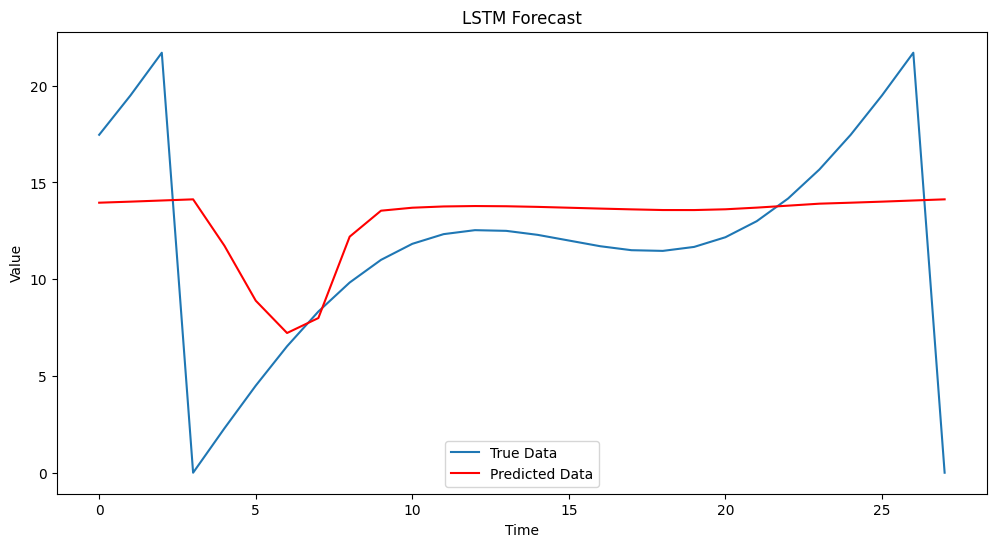

In [36]:
# 进行预测
lstm_y_pred = model.predict(X_test)

# 反归一化
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(lstm_y_pred)

# 绘制结果
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test_inv)), y_test_inv, label='True Data')
plt.plot(np.arange(len(y_pred_inv)), y_pred_inv, label='Predicted Data', color='red')
plt.legend()
plt.title('LSTM Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

准备数据：对时间序列数据进行归一化和滞后特征创建。
构建LSTM模型：使用Keras构建一个LSTM模型。这里使用了两层LSTM层和一层Dense层。return_sequences=True 参数用于在LSTM层之间传递序列。
训练模型：训练模型并评估性能。
进行预测：使用模型进行未来数据的预测并可视化结果。
注意事项
数据处理：确保数据经过适当的预处理（如归一化）以适应神经网络。
参数调整：根据数据集的实际情况调整LSTM的超参数，例如时间步长（lag）、LSTM单元数（units）、训练轮数（epochs）等。
模型复杂性：对于复杂的时间序列问题，可能需要使用更复杂的网络架构或尝试不同的超参数组合。

In [43]:
import numpy as np
from sklearn.metrics import mean_squared_error

# 示例预测结果和测试数据
rnn_y_pred = np.random.rand(100, 1, 1)  # 示例数据
lstm_y_pred = np.random.rand(100, 1, 1)  # 示例数据
X_test = np.random.rand(100, 1, 1)  # 示例数据

# 展平预测结果和测试数据
rnn_y_pred_flat = rnn_y_pred.reshape(-1)
lstm_y_pred_flat = lstm_y_pred.reshape(-1)
X_test_flat = X_test.reshape(-1)

# 确保没有 NaN 或 Inf 值
rnn_y_pred_flat = np.nan_to_num(rnn_y_pred_flat)
lstm_y_pred_flat = np.nan_to_num(lstm_y_pred_flat)
X_test_flat = np.nan_to_num(X_test_flat)

# 计算均方误差
rnn_mse = mean_squared_error(X_test_flat, rnn_y_pred_flat)
lstm_mse = mean_squared_error(X_test_flat, lstm_y_pred_flat)

print(f'RNN MSE: {rnn_mse}')
print(f'LSTM MSE: {lstm_mse}')


RNN MSE: 0.17053160734827214
LSTM MSE: 0.1563124657042902


ARIMA MSE: 30.097640377232064


ARIMA 適合處理線性、平穩的時間序列，具有較低的計算複雜度。
RNN 和 LSTM 更適合處理具有複雜長期依賴性和非線性關係的時間序列，但需要更多的計算資源和時間。
比較這些模型的時候，可以根據預測準確度、計算複雜度和數據特徵來選擇合適的模型。